In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [1]:
from import_modules_stdm import *

with open('config_stdm.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

# Training

In [2]:
thetas, ps = standard_map(init_points=cfg["stdm"]["init_points"], steps=cfg["stdm"]["steps"], K=cfg["stdm"]["K"], seed=None)
thetas.shape, ps.shape

((200, 3), (200, 3))

In [3]:
if cfg["model"]["window_size"] > cfg["stdm"]["steps"]:
    print("Increase total step count!")

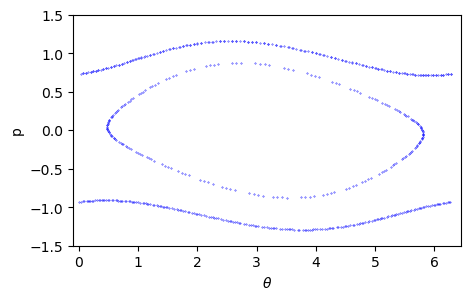

In [4]:
plt.figure(figsize=(5, 3))
plt.plot(thetas, ps, 'bo', markersize=0.3)
plt.xlabel(r"$\theta$")
plt.ylabel("p")
plt.xlim(-0.1, 2.05 * np.pi)
plt.ylim(-1.5, 1.5)
plt.show()

In [5]:
ml_train = ML(window_size=cfg["model"]["window_size"], step_size=cfg["model"]["step_size"], train_size=cfg["model"]["train_size"], val_size=cfg["model"]["val_size"])

thetas = ML.preprocess(thetas)

X, y = ml_train.make_sequences(thetas, ps, sequences=cfg["model"]["sequences"])
print(X.shape, y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=cfg["model"]["val_size"], shuffle=cfg["model"]["shuffle"])

(450, 50, 2) (450, 2)


In [6]:
X_train = torch.Tensor(np.array(X_train))
X_val = torch.Tensor(np.array(X_val))
y_train = torch.Tensor(np.array(y_train))
y_val = torch.Tensor(np.array(y_val))

In [7]:
cfg["train"]["batch_size"], X_train.shape[0]//cfg["train"]["batch_size"]

(100, 3)

Model

In [8]:
model = Model(input_size=X_train.shape[-1], hidden_size=cfg["model"]["hidden_units"], dropout=cfg["model"]["dropout"], num_layers=cfg["model"]["num_layers"], model_type="GRU")

pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters =", pytorch_total_params)

Total number of parameters = 13186


c:\Users\Grand\anaconda3\envs\Magistrska\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [9]:
# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=cfg["train"]["batch_size"], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=cfg["train"]["batch_size"], shuffle=False)

In [10]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=cfg["train"]["learn_rate"])

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (GRU): GRU(2, 64, batch_first=True, dropout=0.01)
  (dense): Linear(in_features=64, out_features=2, bias=True)
)

In [11]:
train_loss, val_loss, model = ml_train.gradient_descent(model, cfg["train"]["epochs"], train_loader, optimizer, device, val_loader, train_dataset, val_dataset, criterion, verbose=1)

Training Epochs: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, Train_loss=2.015e-02, Val_loss=3.615e-02]

Best epoch: 98


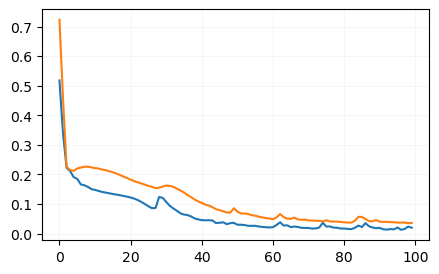

In [12]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss, color='tab:blue')
plt.plot(val_loss, color='tab:orange')
plt.grid(alpha=0.1)

# Testing

In [13]:
thetas_test, ps_test = standard_map(init_points=cfg["stdm"]["init_points"]+20, steps=cfg["stdm"]["steps"], K=cfg["stdm"]["K"])
thetas_test.shape, ps_test.shape

((200, 23), (200, 23))

In [14]:
ml_test = ML(window_size=cfg["model"]["window_size"], step_size=cfg["model"]["step_size"], train_size=cfg["model"]["train_size"], val_size=cfg["model"]["val_size"])

thetas_test = ML.preprocess(thetas_test)

X_test, y_test = ml_test.make_sequences(thetas_test, ps_test, sequences=cfg["model"]["sequences"], predict=True)
print(X_test.shape, y_test.shape)

X_test = torch.Tensor(np.array(X_test))

(23, 50, 2) (23, 150, 2)


In [15]:
test_preds = ml_test.predictions(model=model, device=device, seed=X_test, num_predictions=y_test.shape[1], sequences=cfg["model"]["sequences"])
test_preds.shape, y_test.shape

Predictions: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]


((23, 150, 2), (23, 150, 2))

In [16]:
# for k in range(test_preds.shape[0]):
#     plt.plot(test_preds[k, :, 0], test_preds[k, :, 1], "bo", markersize=1)
#     plt.plot(y_test[k, :, 0], y_test[k, :, 1], "ro", markersize=0.5)
#     plt.plot(test_preds[k, 0, 0], test_preds[k, 0, 1], "bo", markersize=5)
#     plt.xlim(-1.1, 1.1)
#     plt.ylim(-1.5, 1.5)

#     filename = f"plot_{k}.png"
#     plt.savefig(os.path.join("data_stdm/", filename))

#     plt.close()

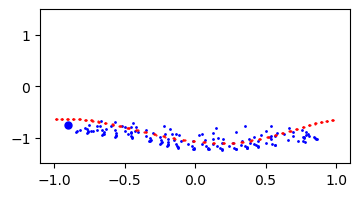

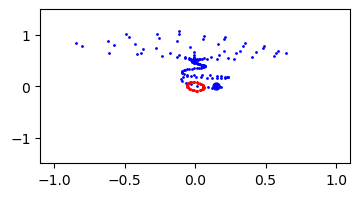

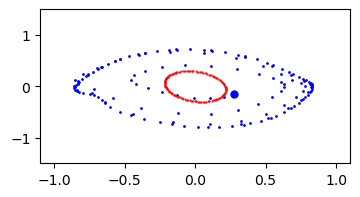

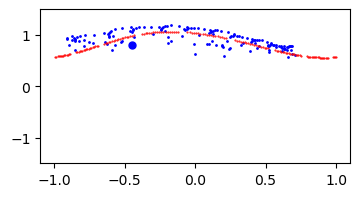

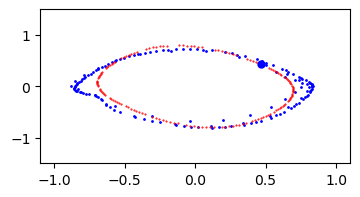

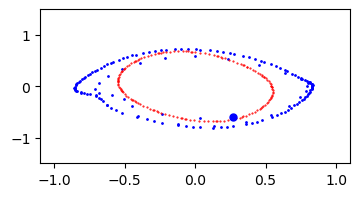

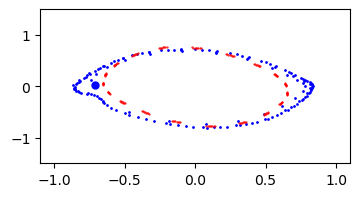

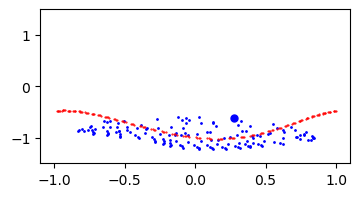

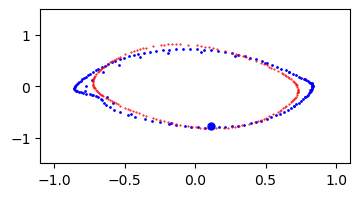

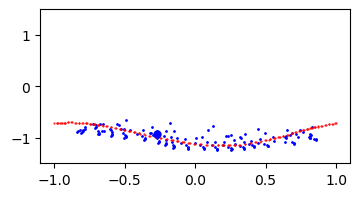

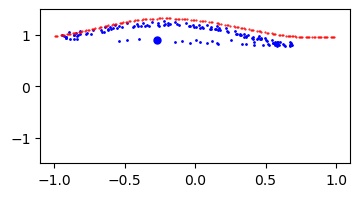

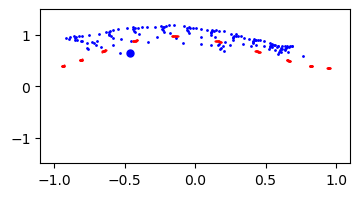

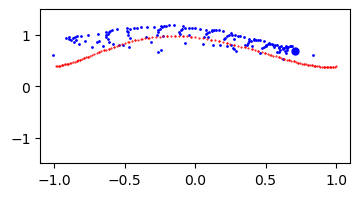

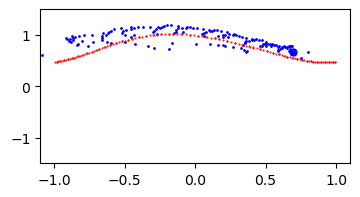

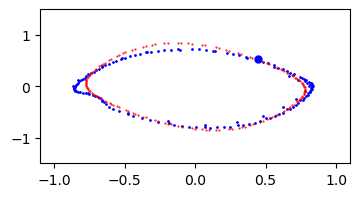

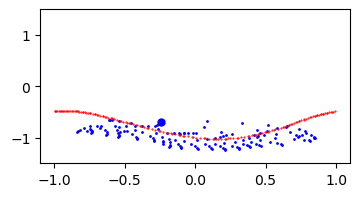

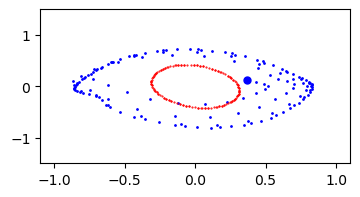

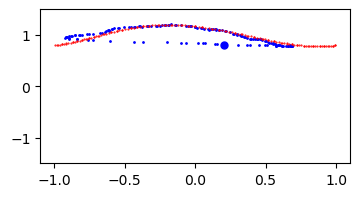

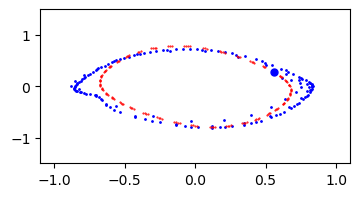

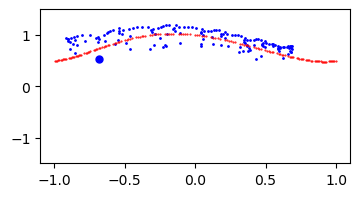

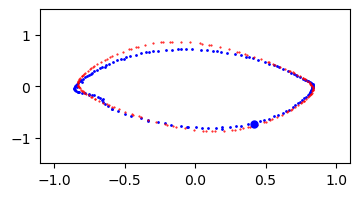

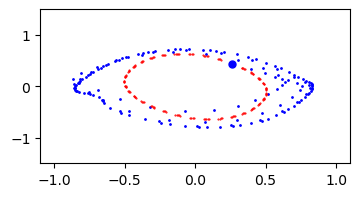

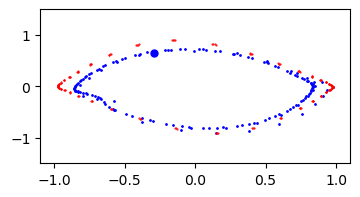

In [17]:
if cfg["model"]["sequences"] == "linear":
    for k in range(test_preds.shape[0]):
        plt.figure(figsize=(4, 2))
        plt.plot(test_preds[k, :, 0], test_preds[k, :, 1], "bo", markersize=1)
        plt.plot(y_test[k, :, 0], y_test[k, :, 1], "ro", markersize=0.5)
        plt.plot(test_preds[k, 0, 0], test_preds[k, 0, 1], "bo", markersize=5)

        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.5, 1.5)

        plt.show()
    
elif cfg["model"]["sequences"] == "parallel":
    for k in range(10):
        plt.figure(figsize=(4, 2))
        plt.plot(test_preds[:, :, 2*k], test_preds[:, :, 2*k+1], "bo", markersize=1)
        plt.plot(y_test[:, :, 2*k], y_test[:, :, 2*k+1], "ro", markersize=0.5)

        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.5, 1.5)

        plt.show()

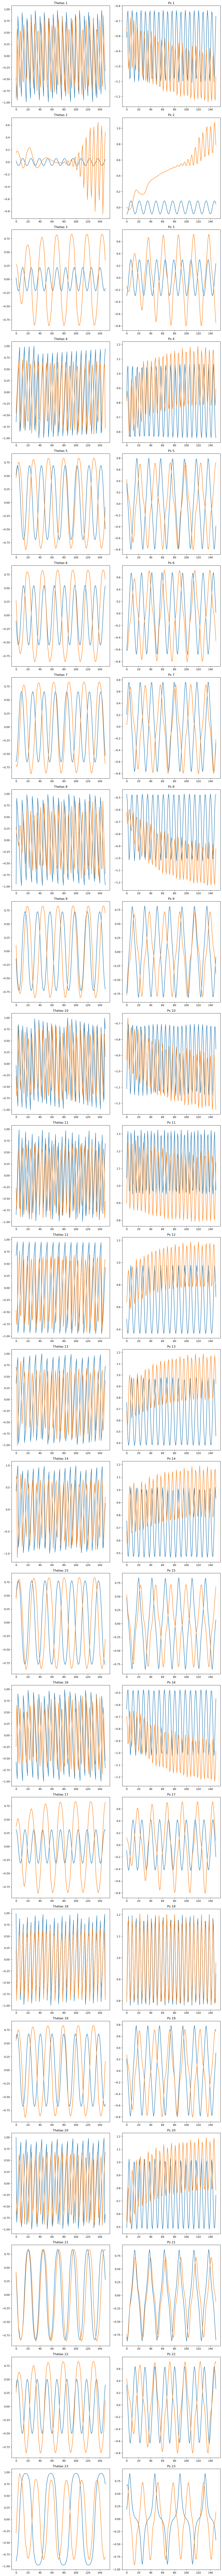

In [18]:
num_plots = test_preds.shape[0]
steps = test_preds.shape[1]

fig, ax = plt.subplots(num_plots, 2, figsize=(12, 6 * num_plots))

for k in range(num_plots):
    ax[k, 0].set_title(f"Thetas {k+1}")
    ax[k, 0].plot(np.arange(steps), y_test[k, :, 0], "tab:blue")
    ax[k, 0].plot(np.arange(steps), test_preds[k, :, 0], "tab:orange")
    ax[k, 1].set_title(f"Ps {k+1}")
    ax[k, 1].plot(np.arange(steps), y_test[k, :, 1], "tab:blue")
    ax[k, 1].plot(np.arange(steps), test_preds[k, :, 1], "tab:orange")

plt.tight_layout()
plt.show()